### **GRU(Gated Recurrent Units)**

LSTM을 조금 더 단순화 시킨 모델 

Hidden State가 Cell State의 역할까지 같이 수행 

$Forgot Gate + Input Gate = Update Gate$

$Output Gate = Reset Gate$

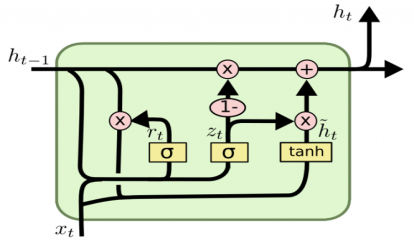

### **Update Gate**

LSTM의 Forgot Gate와 Input Gate의 역할을 모두 담당 

- $Zt$ : 이전 정보의 비율을 결정 - 이전 은닉상태(정보)를 얼마나 유지하는지 
- $1-Zt$ : 현재 정보의 비율을 결정 - 새로운 정보를 얼마나 받을지

- 즉 과거의 정보를 얼마만큼 가져가고 새로운 정보를 얼마나 받아들일지 결정

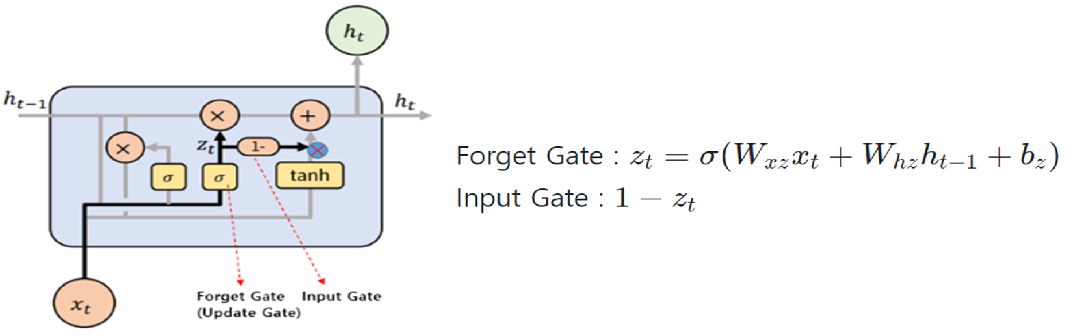

### **Reset Gate**

- LSTM의 Output Gate와 유사한 역살
- 이전 정보에서 얼마 만큼을 선택해서 내보낼지 = 이전 은닉 상태(정보)에서 얼마를 잊고 얼마나 기억할지

- LSTM의 output gate는 최종 출력에서 output으로 나갈 정보를 선별한다면 GRU의 Reset Gate는 이전 정보에서 미리 내보낼 정보를 선별하는 정도로 처리 순서가 다름

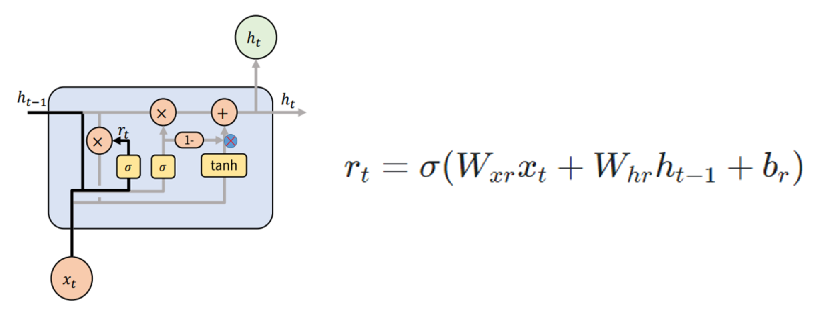

### **Hidden State**

1) Reset Gate, Update Gate (Forget Gate + Input Gate)를 모두 적용하여 Hidden State를 계산
2) 이전 정보에 Reset Gate의 결과를 곱하여 이전 정보 중 출력($h_t$)으로 내보낼 정보를 선별
3) 위의의 결과에 Tanh를 적용


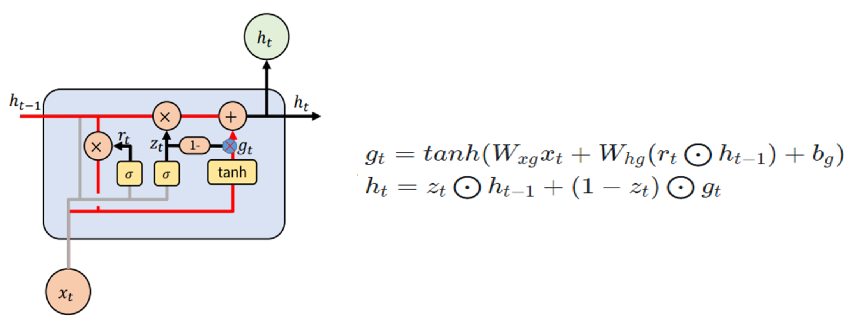

### **GRU Cell**

In [ ]:
import torch
import torch.nn as nn

class gru1(nn.Module):
    def __init__(self, in_dim, hi_dim):
        super().__init__()
        
        self.hi_dim = hi_dim
        
        # reset gate
        self.wr = nn.Linear(in_dim, hi_dim)
        self.wrh = nn.Linear(hi_dim, hi_dim)
        
        # update gate
        self.wz = nn.Linear(in_dim, hi_dim)
        self.wzh = nn.Linear(hi_dim, hi_dim)
        
        # candidate
        self.wh = nn.Linear(in_dim, hi_dim)
        self.whh = nn.Linear(hi_dim, hi_dim)
        
        
    def forward(self, x, ht_1):
        
        # reset gate
        r_t = torch.sigmoid(self.wr(x) + self.wrh(ht_1))
        
        # update gate
        z_t = torch.sigmoid(self.wz(x) + self.wzh(ht_1))
        
        
        r_ht_1 = r_t * ht_1
        
        # candidate    reset gate를 통해 이전 정보를 일부 리셋하고 새로운 입력과 결합하여 후보군 선정
        h_hat_t = torch.tanh(self.wh(x) + self.whh(r_ht_1))
        
        
        # hidden state
        h_t = z_t * ht_1 + (1-z_t) * h_hat_t
        
        return h_t


class gru2(nn.Module):
    def __init__(self, in_dim, hi_dim):
        super().__init__()
        
        self.hi_dim = hi_dim
        
        # reset gate
        self.wr = nn.Linear(in_dim + hi_dim, hi_dim)
        
        # update gate
        self.wz = nn.Linear(in_dim + hi_dim, hi_dim)
        
        # candidate
        self.wh = nn.Linear(in_dim + hi_dim, hi_dim)
        
        
    def forward(self, x, ht_1):
        
        x_ht_1 = torch.cat([x, ht_1], dim = 1)
        
        # reset gate
        r_t = torch.sigmoid(self.wr(x_ht_1))
        
        # update gate
        z_t = torch.sigmoid(self.wz(x_ht_1))
        
        
        # candidate    reset gate를 통해 이전 정보를 일부 리셋하고 새로운 입력과 결합하여 후보군 선정
        r_ht_1 = r_t * ht_1
        
        x_r_ht_1 = torch.cat([x, r_ht_1], dim = 1)
        
        h_hat_t = torch.tanh(self.wh(x_r_ht_1))
        
        # hidden state
        h_t = z_t * ht_1 + (1-z_t) * h_hat_t
        
        return h_t


### **nn.GRU**

pytorch에서 제공하는 gru cell

In [1]:
import torch.nn as nn


class _GRU(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        
    
        self.gru = nn.GRU(in_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        
        out, _ = self.gru(x)
        out = self.fc(out[:, -1])
        
        return out
    